# Classify Waste Products Using Transfer Learning

### 1. Aim of the Proyect

The aim of the project is to develop an automated waste classification model that can accurately differentiate between recyclable and organic waste based on images.

### 2. Importing Required Libraries

In [2]:
import numpy as np
import os
import random, shutil
import glob
from matplotlib import pyplot as plt
from matplotlib import pyplot
from matplotlib.image import imread
from os import makedirs,listdir
from shutil import copyfile
from random import seed
from random import random
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D, Input
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')

### 3. Downloading Datasets

I'm using [Waste Classification Dataset](https://github.com/FernandoC31/Classify-Waste-Products-Using-Transfer-Learning/raw/refs/heads/main/o-vs-r-split.zip) that is a zip that contains images of **organic and recycable** waste images separetes in **Train** and **Test** folder in the following structure

```python
o-vs-r-split/
└── train
    ├── O
    └── R
└── test
    ├── O
    └── R
```

In [3]:
import requests
import zipfile
from tqdm import tqdm

url = "https://github.com/FernandoC31/Classify-Waste-Products-Using-Transfer-Learning/raw/refs/heads/main/o-vs-r-split.zip"
file_name = "o-vs-r-split.zip"

print("Downloading file")
with requests.get(url, stream=True) as response:
    response.raise_for_status()
    with open(file_name, 'wb') as f:
        for chunk in response.iter_content(chunk_size=8192):
            f.write(chunk)
def extract_file_with_progress(file_name):
    print("Extracting file with progress")
    with zipfile.ZipFile(file_name, 'r') as zip_ref:
        members = zip_ref.infolist() 
        with tqdm(total=len(members), unit='file') as progress_bar:
            for member in members:
                zip_ref.extract(member)
                progress_bar.update(1)
    print("Finished extracting file")
extract_file_with_progress(file_name)
print("Finished extracting file")
os.remove(file_name)

Extracting file with progress


100%|██████████| 1207/1207 [00:00<00:00, 1313.41file/s]

Finished extracting file
Finished extracting file


### 4. Configuration of the model

In this case I used the following configutarion:
*   **Batch size** is set to 64.
*   The **number of classes** is 2.
*   You will use 20% of the data for **validation** purposes.
*   **Target size** in generating images 150x150 px
*   **Number of epochs** will be 15
*   A **Seed** of 42 
*   You have two **labels** in your dataset: organic (O), recyclable (R).

In [4]:
batch_size = 64
n_classes = 2
val_split = 0.2
img_rows, img_cols = 150, 150
n_epochs = 15
verbosity = 1
path = 'o-vs-r-split/train/'
path_test = 'o-vs-r-split/test/'
input_shape = (img_rows, img_cols, 3)
labels = ['O', 'R']
seed = 42

In this case I used ImageDataGenerator but what is this tool ?
>ImageDataGenerator is a tool for **Data Augmentation**, generating new training data by applying transformations like scaling, rotation, and flipping. This increases dataset diversity, prevents **Overfitting** and improves model generalization.

Also I Rescaled the pixels values that they are in a range of $ [0-255] $ and when it's divided by 255 we normalize the range to $ [0-1]$ which **improves** model performance

In [5]:
train_datagen = ImageDataGenerator(
    validation_split = val_split,
    rescale=1.0/255.0,
	width_shift_range=0.1, 
    height_shift_range=0.1, 
    horizontal_flip=True)

val_datagen = ImageDataGenerator(
    validation_split = val_split,
    rescale=1.0/255.0)
test_datagen = ImageDataGenerator(
    rescale=1.0/255.0)

In [6]:
train_generator = train_datagen.flow_from_directory(
    directory = path,
    seed = seed,
    batch_size = batch_size, 
    class_mode='binary',
    shuffle = True,
    target_size=(img_rows, img_cols),
    subset = 'training')

Found 800 images belonging to 2 classes.


In [7]:
val_generator = val_datagen.flow_from_directory(
    directory = path,
    seed = seed,
    batch_size = batch_size, 
    class_mode='binary',
    shuffle = True,
    target_size=(img_rows, img_cols),
    subset = 'validation')

Found 200 images belonging to 2 classes.


In [8]:
test_generator = test_datagen.flow_from_directory(
    directory = path_test,
    seed = seed,
    batch_size = batch_size, 
    class_mode='binary',
    shuffle = True,
    target_size=(img_rows, img_cols),
)

Found 200 images belonging to 2 classes.


#### Let's view an examples of the augmented data

Labels: ['O', 'O', 'O', 'O', 'O']


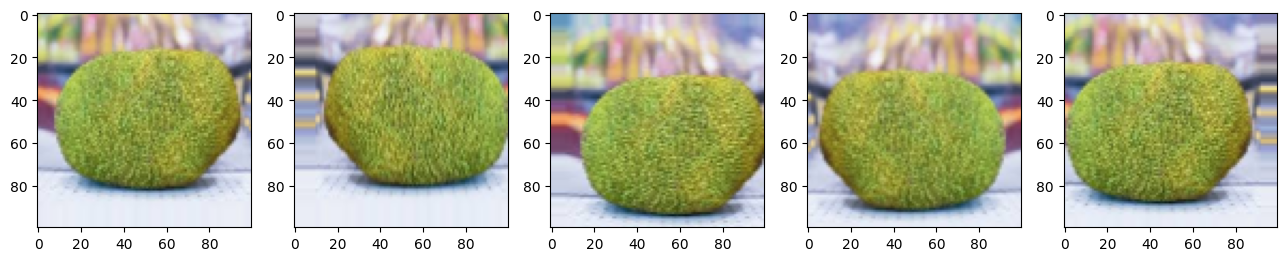

In [9]:
from pathlib import Path

IMG_DIM = (100, 100)

train_files = glob.glob('./o-vs-r-split/train/O/*')
train_files = train_files[:40]
train_imgs = [tf.keras.preprocessing.image.img_to_array(tf.keras.preprocessing.image.load_img(img, target_size=IMG_DIM)) for img in train_files]
train_imgs = np.array(train_imgs)
train_labels = [Path(fn).parent.name for fn in train_files]

img_id = 6
O_generator = train_datagen.flow(train_imgs[img_id:img_id+1], train_labels[img_id:img_id+1],
                                   batch_size=1)
O = [next(O_generator) for i in range(0,5)]
fig, ax = plt.subplots(1,5, figsize=(16, 6))
print('Labels:', [item[1][0] for item in O])
l = [ax[i].imshow(O[i][0][0]) for i in range(0,5)]

### 5. Using Pre-Trained models

A pre- trained model is a neural network trained on a large dataset. It can be reused for new tasks, saving time and computational resources, by fine-tuning it for specific applications. In this case we use **VGG16**
>VGG16 is a **Convolutional Neural Network (CNN)** with 16 layers, used for image classification. It uses 3x3 convolution layers to capture features and fully connected layers for predictions. Pretrained on ImageNet, VGG16 can be fine-tuned for specific tasks like object recognition.

In [10]:
from tensorflow.keras.applications import vgg16
input_shape = (150, 150, 3)
vgg = vgg16.VGG16(include_top=False,
                        weights='imagenet',
                        input_shape=input_shape)

In [11]:
output = vgg.layers[-1].output
output = tf.keras.layers.Flatten()(output)
basemodel = Model(vgg.input, output)

In [12]:
for layer in basemodel.layers: 
    layer.trainable = False

We **freeze** the layers of a pretrained model (VGG16) during transfer learning. This is useful when you want to leverage the pretrained model's feature extraction capabilities

In [13]:
model = Sequential()
model.add(basemodel)
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ functional (Functional)         │ (None, 8192)           │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     4,194,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,172,673 (73.14 MB)

 Trainable params: 4,457,985 (17.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

The sequence of Dense layers (ReLU, ReLU, and then Sigmoid) is a common pattern in neural networks, especially when building a model for **binary classification** like in this proyect

We add Dropout to neural networks to help **prevent overfitting** and improve the model's generalization ability

In [14]:
model.compile(
    loss='binary_crossentropy',
    optimizer=optimizers.RMSprop(learning_rate=1e-4),
    metrics=['accuracy'])

### 6. Using Callbacks

>A callback in Keras is a function or set of functions that are executed at specific points **during the training process**. Callbacks provide a way to monitor and modify the training procedure, allowing for **more control** over the model's training lifecycle.

* **LearningRateScheduler:** Adjusts the learning rate during training using an exponential decay function.
* **LossHistory_:** A custom callback that saves and prints the loss value and learning rate after each epoch.
* **exp_decay:** A function that defines how the learning rate decays, reducing it gradually as epochs progress.
* **EarlyStopping:** Stops training if the validation loss does not improve after a certain number of epochs, helping to prevent overfitting.
* **ModelCheckpoint:** Saves the model with the best validation performance, ensuring the model with the lowest validation loss is preserved.

These callbacks are combined into a list and passed to the model training process, providing **enhanced control over training, optimizing performance, and preventing overfitting.** 

In [15]:
from tensorflow.keras.callbacks import LearningRateScheduler
checkpoint_path='O_R_tlearn_vgg16.keras'

class LossHistory_(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.lr = []
        
    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))
        self.lr.append(exp_decay(epoch))
        print('lr:', exp_decay(len(self.losses)))

def exp_decay(epoch):
    initial_lrate = 1e-4
    k = 0.1
    lrate = initial_lrate * np.exp(-k*epoch)
    return lrate

loss_history_ = LossHistory_()
lrate_ = LearningRateScheduler(exp_decay)
keras_callbacks = [
      EarlyStopping(monitor = 'val_loss', 
                    patience = 4, 
                    mode = 'min', 
                    min_delta=0.01),
      ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min')
]
callbacks_list_ = [loss_history_, lrate_] + keras_callbacks

In [16]:
extract_feat_model = model.fit(train_generator, 
                               epochs=n_epochs,
                               callbacks = callbacks_list_,   
                               validation_data=val_generator, 
                               verbose=1)

Epoch 1/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6437 - loss: 0.6342lr: 9.048374180359596e-05
13/13 ━━━━━━━━━━━━━━━━━━━━ 38s 3s/step - accuracy: 0.6467 - loss: 0.6303 - val_accuracy: 0.8500 - val_loss: 0.3910 - learning_rate: 1.0000e-04
Epoch 2/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8190 - loss: 0.4189lr: 8.187307530779819e-05
13/13 ━━━━━━━━━━━━━━━━━━━━ 38s 3s/step - accuracy: 0.8176 - loss: 0.4210 - val_accuracy: 0.7400 - val_loss: 0.4715 - learning_rate: 9.0484e-05
Epoch 3/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8115 - loss: 0.3997lr: 7.408182206817179e-05
13/13 ━━━━━━━━━━━━━━━━━━━━ 39s 3s/step - accuracy: 0.8133 - loss: 0.3979 - val_accuracy: 0.8850 - val_loss: 0.2989 - learning_rate: 8.1873e-05
Epoch 4/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8672 - loss: 0.3154lr: 6.703200460356394e-05
13/13 ━━━━━━━━━━━━━━━━━━━━ 37s 3s/step - accuracy: 0.8665 - loss: 0.3160 - val_accuracy: 0.9100 - val_loss: 0.2754 - learning_rate: 7.4082e

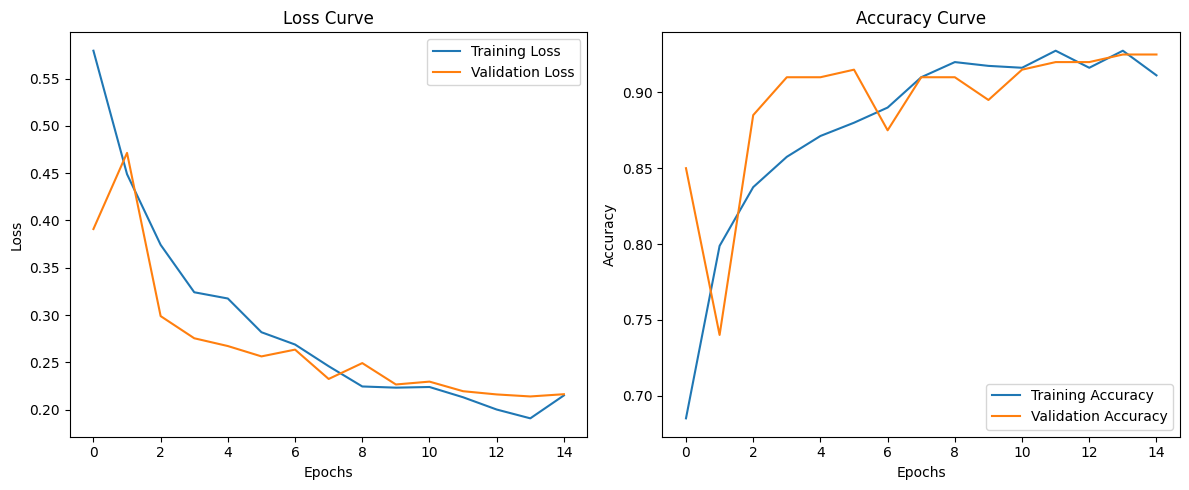

In [17]:
import matplotlib.pyplot as plt

history = extract_feat_model
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


>The model demonstrates **solid performance**, with training accuracy consistently above 90% and validation accuracy around 90%. The losses are also relatively low, indicating effective learning and generalization. Although there are slight fluctuations in validation accuracy across epochs, the overall trend suggests that the model **is not overfitting**. Given the stable performance and low loss values, this model can be considered robust and suitable for deployment in its current state.

### 7. Fine-Tuning the model

It is refers to the proceess of making small adjustments or refinements to a model, typically after it has already been trained on a large dataset. The goal is to improve the model's performance on a specific task or dataset by modifying its parameters, such as the learning rate, number of epochs, or layers, in a controlled manner. In this case we'll unfreeze **one layer** from the base modal.

In [18]:
from tensorflow.keras.applications import vgg16

input_shape = (150, 150, 3)
vgg = vgg16.VGG16(include_top=False,
                        weights='imagenet',
                        input_shape=input_shape)

output = vgg.layers[-1].output
output = tf.keras.layers.Flatten()(output)
basemodel = Model(vgg.input, output)

for layer in basemodel.layers: 
    layer.trainable = False

display([layer.name for layer in basemodel.layers])
set_trainable = False
for layer in basemodel.layers:
    if layer.name in ['block5_conv3']:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
for layer in basemodel.layers:
    print(f"{layer.name}: {layer.trainable}")

['input_layer_2',
 'block1_conv1',
 'block1_conv2',
 'block1_pool',
 'block2_conv1',
 'block2_conv2',
 'block2_pool',
 'block3_conv1',
 'block3_conv2',
 'block3_conv3',
 'block3_pool',
 'block4_conv1',
 'block4_conv2',
 'block4_conv3',
 'block4_pool',
 'block5_conv1',
 'block5_conv2',
 'block5_conv3',
 'block5_pool',
 'flatten_1']

input_layer_2: False
block1_conv1: False
block1_conv2: False
block1_pool: False
block2_conv1: False
block2_conv2: False
block2_pool: False
block3_conv1: False
block3_conv2: False
block3_conv3: False
block3_pool: False
block4_conv1: False
block4_conv2: False
block4_conv3: False
block4_pool: False
block5_conv1: False
block5_conv2: False
block5_conv3: True
block5_pool: True
flatten_1: True


We will create a new model with this change in the base model and we will called ***fine_tune_model*** with the aim to compare with the previus model ***extract_feat_model***

In [31]:
model = Sequential()
model.add(basemodel)
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

checkpoint_path='O_R_tlearn_fine_tune_vgg16.keras'

loss_history_ = LossHistory_()
lrate_ = LearningRateScheduler(exp_decay)

keras_callbacks = [
      EarlyStopping(monitor = 'val_loss', 
                    patience = 4, 
                    mode = 'min', 
                    min_delta=0.01),
      ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min')
]

callbacks_list_ = [loss_history_, lrate_] + keras_callbacks

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-4),
              metrics=['accuracy'])

fine_tune_model = model.fit(train_generator, 
                    epochs=n_epochs,
                    callbacks = callbacks_list_,   
                    validation_data=val_generator,  
                    verbose=1)

Epoch 1/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7368 - loss: 0.4990lr: 9.048374180359596e-05
13/13 ━━━━━━━━━━━━━━━━━━━━ 37s 3s/step - accuracy: 0.7416 - loss: 0.4928 - val_accuracy: 0.8350 - val_loss: 0.3363 - learning_rate: 1.0000e-04
Epoch 2/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9214 - loss: 0.2129lr: 8.187307530779819e-05
13/13 ━━━━━━━━━━━━━━━━━━━━ 35s 3s/step - accuracy: 0.9210 - loss: 0.2133 - val_accuracy: 0.6650 - val_loss: 0.8103 - learning_rate: 9.0484e-05
Epoch 3/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8936 - loss: 0.2622lr: 7.408182206817179e-05
13/13 ━━━━━━━━━━━━━━━━━━━━ 35s 3s/step - accuracy: 0.8959 - loss: 0.2570 - val_accuracy: 0.9050 - val_loss: 0.1880 - learning_rate: 8.1873e-05
Epoch 4/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9636 - loss: 0.1156lr: 6.703200460356394e-05
13/13 ━━━━━━━━━━━━━━━━━━━━ 35s 3s/step - accuracy: 0.9636 - loss: 0.1152 - val_accuracy: 0.9150 - val_loss: 0.1693 - learning_rate: 7.4082e

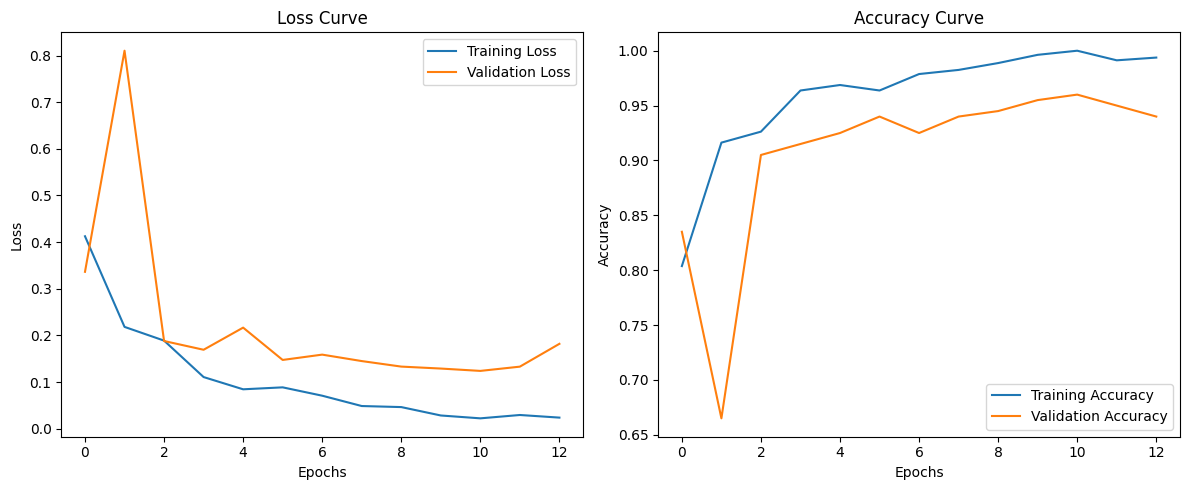

In [33]:
history = fine_tune_model
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

### 8. Evaluating the model on the test data

In [34]:
from pathlib import Path

extract_feat_model = tf.keras.models.load_model('O_R_tlearn_vgg16.keras')
fine_tune_model = tf.keras.models.load_model('O_R_tlearn_fine_tune_vgg16.keras')

IMG_DIM = (150, 150)

test_files_O = glob.glob('./o-vs-r-split/test/O/*')
test_files_R = glob.glob('./o-vs-r-split/test/R/*')
test_files = test_files_O[:100] + test_files_R[:100]

test_imgs = [tf.keras.preprocessing.image.img_to_array(tf.keras.preprocessing.image.load_img(img, target_size=IMG_DIM)) for img in test_files]
test_imgs = np.array(test_imgs)
test_labels = [Path(fn).parent.name for fn in test_files]

test_imgs_scaled = test_imgs.astype('float32')
test_imgs_scaled /= 255

class2num_lt = lambda l: [0 if x == 'O' else 1 for x in l]
num2class_lt = lambda l: ['O' if x < 0.5 else 'R' for x in l]

test_labels_enc = class2num_lt(test_labels)

predictions_extract_feat_model = extract_feat_model.predict(test_imgs_scaled, verbose=0)
predictions_fine_tune_model = fine_tune_model.predict(test_imgs_scaled, verbose=0)

predictions_extract_feat_model = num2class_lt(predictions_extract_feat_model)
predictions_fine_tune_model = num2class_lt(predictions_fine_tune_model)

print('Extract Features Model')
print(metrics.classification_report(test_labels, predictions_extract_feat_model))
print('Fine-Tuned Model')
print(metrics.classification_report(test_labels, predictions_fine_tune_model))

Extract Features Model
              precision    recall  f1-score   support

           O       0.84      0.90      0.87       100
           R       0.89      0.83      0.86       100

    accuracy                           0.86       200
   macro avg       0.87      0.86      0.86       200
weighted avg       0.87      0.86      0.86       200

Fine-Tuned Model
              precision    recall  f1-score   support

           O       0.87      0.90      0.88       100
           R       0.90      0.86      0.88       100

    accuracy                           0.88       200
   macro avg       0.88      0.88      0.88       200
weighted avg       0.88      0.88      0.88       200



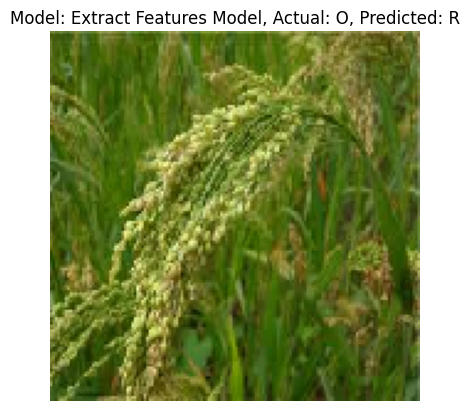

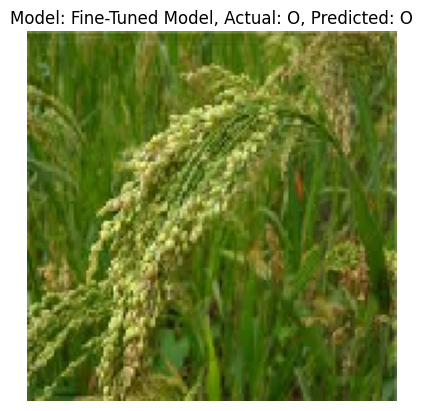

In [36]:
def plot_image_with_title(image, model_name, actual_label, predicted_label):
    plt.imshow(image)
    plt.title(f"Model: {model_name}, Actual: {actual_label}, Predicted: {predicted_label}")
    plt.axis('off')
    plt.show()

index_to_plot = 2
plot_image_with_title(
    image=test_imgs[index_to_plot].astype('uint8'),
    model_name='Extract Features Model',
    actual_label=test_labels[index_to_plot], 
    predicted_label=predictions_extract_feat_model[index_to_plot],
    )
index_to_plot = 2
plot_image_with_title(
    image=test_imgs[index_to_plot].astype('uint8'),
    model_name='Fine-Tuned Model',
    actual_label=test_labels[index_to_plot], 
    predicted_label=predictions_fine_tune_model[index_to_plot],
    )

### 9. Conclusion

* The fine-tuned model demonstrates better overall performance with a 2% increase in accuracy (0.88 vs. 0.86) and improved precision for class O (0.87 vs. 0.84), indicating that the model produces fewer false positives for this class. Similarly, the precision for class R remains high (0.90), reflecting consistent classification reliability for this class.

* The recall for class O remains stable at 0.90, showing that the fine-tuned model maintains its ability to correctly identify true positives for this class. Meanwhile, the recall for class R has increased slightly (from 0.83 to 0.86), demonstrating that the model now captures more true positives for class R, leading to better sensitivity.

* The F1-scores for both classes (O and R) have improved (from 0.87 and 0.86 to 0.88 for both), highlighting a more balanced trade-off between precision and recall. This balance suggests that the fine-tuned model generalizes better without favoring one class over the other.

* Overall, the fine-tuned model offers enhanced classification performance, particularly in its ability to better capture true positives for class R and reduce false positives for class O. Its improved precision, recall, and F1-scores make it the preferred model for reliable and balanced predictions.

In [ ]:
model.save('Classifier_Waste.keras')

Copyright © Fernando Camargo Nieto